# Modeling- Optimizing For Tournament Structure
- Robert Shaw, Sean Coleman, Spencer Evans, Daniel Alpert
- CS109a Project- Data Driven March Madness

---

In this file, we tune our model to the sturcture of the tournament. Using a simulation method, we will attempt to approxiate the maximum expected score (i.e. number of point under the ESPN scoring method).

We also present methods for biasing our predictions towards making "unique" brackets (i.e. those that are much different from choosing the higher seed). We also allow the location of the bias to change (i.e. induce a lot of early round upsets or late round upsets).

---

In [1]:
import march_madness_classes as mmc
import march_madness_games as mmg
import march_madness_models as mmm
import march_madness_train_and_tune as mmtt

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import Lasso as Lasso
from sklearn.ensemble import RandomForestClassifier as random_forest

---
### 1) Generate Head to Head Models

In [2]:
# read in the dataset
seeds = pd.read_csv("datasets/kaggle_data/TourneySeeds.csv")
slots = pd.read_csv("datasets/kaggle_data/TourneySlots.csv")
games = pd.read_csv("datasets/kaggle_data/TourneyCompactResults.csv")

seeds_arr = mmg.filter_into_seasons(seeds)
slots_arr = mmg.filter_into_seasons(slots)
games_arr = mmg.filter_into_seasons(games)

In [3]:
# extract predictors, chosen from the variable selection notebook
markov          = pd.read_csv("datasets/our_data/stationary", index_col=0)
rpi             = pd.read_csv("datasets/our_data/rpi", index_col=0)
bad_losses      = pd.read_csv("datasets/our_data/bad_losses", index_col=0)

# seeds
seed_matrix_df  = pd.read_csv("datasets/our_data/team_summary_data/seeds_matrix", index_col=0)

In [4]:
# get data into correct format
predictor_names = ["min_index_id", "max_index_id", "markov","rpi","bad_losses"] 

# package the predictors into an array
predictor_dfs = [markov, rpi, bad_losses] 

In [5]:
train_test_arr = []

window   = 3
min_year = 2006
max_year = 2014

year_range = range(min_year, max_year)

# generate our train test split for each year
for year in year_range:
    # do the split for the current year
    train_test_tuple = mmtt.train_test_split(window, 
                                             year, 
                                             seeds_arr, 
                                             slots_arr, 
                                             games_arr, 
                                             predictor_names, 
                                             predictor_dfs)
    
    # add to our array
    train_test_arr.append(train_test_tuple)

In [6]:
# our cross validated value of c, from variable selection notebook
c = 1
variables = ["markov","rpi","bad_losses"] 

# models and scalers to be fit
models  = []
scalers = []

for year in year_range:
        # get train data
        train_x = train_test_arr[year - min_year][0][variables]
        train_y = train_test_arr[year - min_year][1].values[:, 0]

        # get cross validation set
        cross_x = train_test_arr[year - min_year][2][variables]
        cross_y = train_test_arr[year - min_year][3].values[:, 0]

        # scaling
        scaler = StandardScaler().fit(train_x)
        scaled_train_x = scaler.transform(train_x)
        scaled_cross_x = scaler.transform(cross_x)

        # init model
        model = LogReg(C=c)

        # fit model
        model.fit(scaled_train_x, train_y)
        
        # append to our lis of models
        models.append(model)
        scalers.append(scaler)

--- 
### 2) Run Simulations

In [18]:
# setup simulator
simulators = []

i = 0
# iterate years
for year in year_range: 
    # get data needed
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]
    
    # setup head to head model
    head_to_head_model_year = mmm.ModelPredictor(models[i], scalers[i], predictor_dfs, year, simulation=True)
    
    # setup simulator
    simulators.append(mmc.Simulator(seeds_year, slots_year, head_to_head_model_year))
    
    i = i + 1

In [22]:
# run simulations
i = 0
for year in year_range:
    # run simulation
    points = simulators[i].simulate_tournament(200) 
    
    # predict bracket based on the simulation
    bracket = simulators[i].predict_tournament()
    
    i = i + 1
    
    print year

2006
2007
2008
2009
2010
2011
2012
2013


---
### 3) Setup Greedy Model/Top Seed Model

In [38]:
year = min_year
greedy_tourneys   = []
top_seed_tourneys = []
actual_tourneys   = []

# analyze results for all simulations
i = 0
for year in year_range:
    # get data from our db
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]
    
    # get actual models
    actual_model = mmm.ActualTournament(games_arr[year-1985])
    actual_tourneys.append(mmc.Tournament(seeds_year, slots_year, actual_model, include_scoring_dif=False))
    
    # get greedy models
    greedy_model = mmm.ModelPredictor(models[i], scalers[i], predictor_dfs, year, simulation=False)
    greedy_tourneys.append(mmc.Tournament(seeds_year, slots_year, greedy_model, include_scoring_dif=False))
    
    # get top seed models
    top_seed_model = mmm.BasicPredictor()
    top_seed_tourneys.append(mmc.Tournament(seeds_year, slots_year, top_seed_model, include_scoring_dif=False))
    
    year = year + 1
    i = i + 1

---
### 4) Analyze Results

- Simulation

In [34]:
year = min_year

simulator_scores = np.zeros(len(year_range))
simulator_accuracys = np.zeros(len(year_range))

# analyze results for all simulations
i = 0
for simulator in simulators:
    # get data from our db
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]
    
    # get actual models
    actual_model = mmm.ActualTournament(games_arr[year-1985])
    actual_tourney = mmc.Tournament(seeds_year, slots_year, actual_model, include_scoring_dif=False)
    
    # score tournament 
    simulator_scores[i], simulator_accuracys[i] = simulator.score_tournament(actual_tourney, print_res=False)
    
    year = year + 1
    i = i + 1

In [35]:
print np.average(simulator_scores)
print np.average(simulator_accuracys)

978.75
0.64880952381


- Greedy Model / Top Seed Model

In [40]:
# buffers
greedy_scores = np.zeros(len(year_range))
greedy_accuracys = np.zeros(len(year_range))

top_seed_scores = np.zeros(len(year_range))
top_seed_accuracys = np.zeros(len(year_range))

# analyze results 
year = min_year
i = 0
for i in range(len(year_range)):
    # get data from our db
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]
    
    # get models
    actual_tourney = actual_tourneys[i]
    greedy_tourney = greedy_tourneys[i]
    top_seed_tourney = top_seed_tourneys[i]
    
    # score tournaments
    greedy_scores[i], greedy_accuracys[i] = greedy_tourney.score_tournament(actual_tourney, print_res=False)
    top_seed_scores[i], top_seed_accuracys[i] = top_seed_tourney.score_tournament(actual_tourney, print_res=False)
    
    year = year + 1
    i = i + 1

In [42]:
print np.average(greedy_scores)
print np.average(greedy_accuracys)

1016.25
0.644841269841


In [48]:
print np.average(top_seed_scores)
print np.average(top_seed_accuracys)

828.75
0.646825396825


In [49]:
print simulator_scores
print greedy_scores
print top_seed_scores

[  620.   910.  1600.   930.   930.   460.  1260.  1120.]
[  620.   940.  1600.  1240.   910.   450.  1250.  1120.]
[  630.  1090.  1140.   900.   620.   570.   880.   800.]


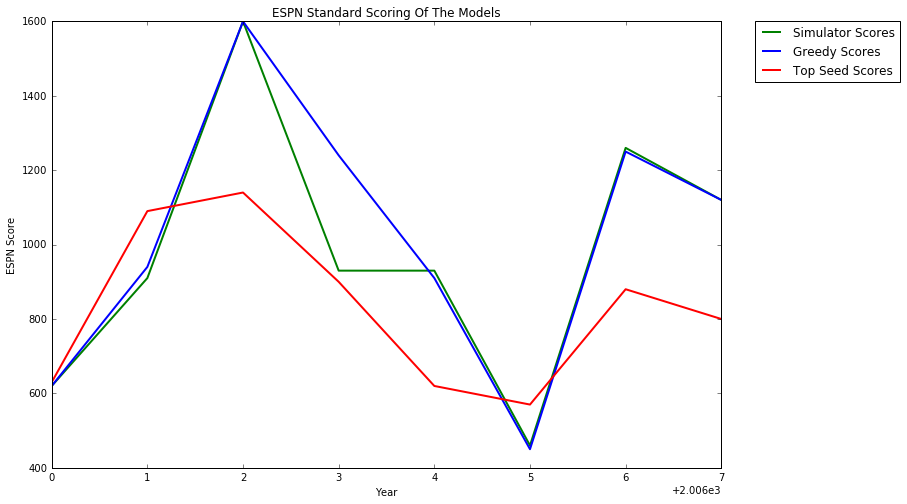

In [69]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(year_range, simulator_scores, c="g", label="Simulator Scores", lw=2)
ax.plot(year_range, greedy_scores, c="b", label = "Greedy Scores", lw=2)
ax.plot(year_range, top_seed_scores, c="r", label= "Top Seed Scores", lw=2)
ax.set_xlabel("Year")
ax.set_ylabel("ESPN Score")
ax.set_title("ESPN Standard Scoring Of The Models")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

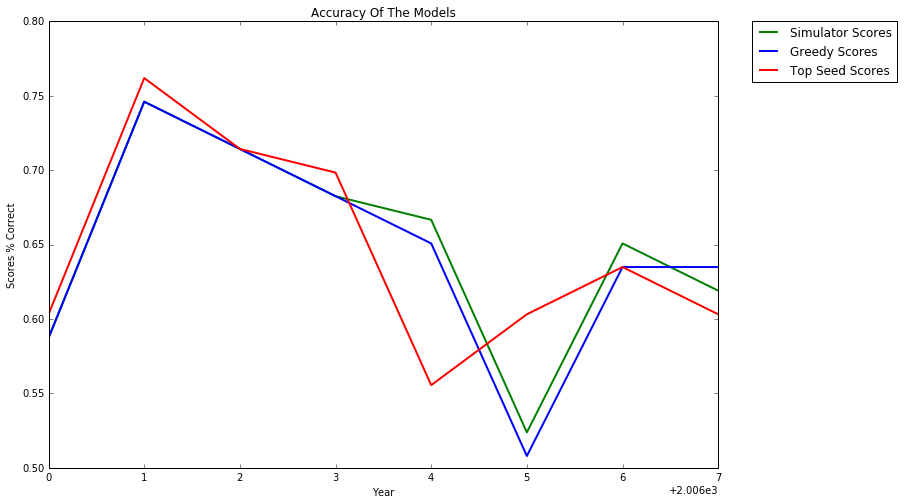

In [65]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(year_range, simulator_accuracys, c="g", label="Simulator Scores", lw=2)
ax.plot(year_range, greedy_accuracys, c="b", label = "Greedy Scores", lw=2)
ax.plot(year_range, top_seed_accuracys, c="r", label= "Top Seed Scores", lw=2)
ax.set_xlabel("Year")
ax.set_ylabel("Scores % Correct")
ax.set_title("Accuracy Of The Models")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

---
### 5) Compare Results Against Eachother

In [79]:
n = len(greedy_tourneys)

greedy_n_dif = np.zeros(n)
greedy_n_correct = np.zeros(n)
greedy_n_other_correct = np.zeros(n)

simulator_n_dif = np.zeros(n)
simulator_n_correct = np.zeros(n)
simulator_n_other_correct = np.zeros(n)

# iterate through our entire list
for i in range(n):
    # comapre
    greedy_n_dif[i], greedy_n_correct[i], greedy_n_other_correct[i] = greedy_tourneys[i].compare_to_dif_tournament(actual_tourneys[i], top_seed_tourneys[i], print_res=False)
    
    simulator_n_dif[i], simulator_n_correct[i], simulator_n_other_correct[i] = simulators[i].tournament_prediction.compare_to_dif_tournament(actual_tourneys[i], top_seed_tourneys[i], print_res=False)

In [81]:
simulator_n_correct_all = np.sum(simulator_n_correct)
simulator_n_other_correct_all = np.sum(simulator_n_other_correct)

print simulator_n_correct_all, simulator_n_other_correct_all

23.0 22.0


In [82]:
greedy_n_correct_all = np.sum(greedy_n_correct)
greedy_n_other_correct_all = np.sum(greedy_n_other_correct)

print greedy_n_correct_all, greedy_n_other_correct_all

24.0 25.0


---

### 6) Introducing Bias

In [249]:
biases = [0, .01, .02, .03, .04, .05, .06, .07, .08, .09, .1, .11, .12, .13, .14, .15, .16, .17, .18, .19, .2]
scores_biased_models = np.zeros((max_year-min_year, len(biases)))
n_games_dif_greedy = np.zeros((max_year-min_year, len(biases)))
n_games_dif_unbiased = np.zeros((max_year-min_year, len(biases)))

In [260]:
# fit biased models
biased_tourneys = []
reload(mmm)
i = 0
for year in year_range:
    j = 0
    print year
    biased_tourneys_year_i = []
    for bias in biases:
        # get data needed
        seeds_year = seeds_arr[year-1985] 
        slots_year = slots_arr[year-1985] 
        games_year = games_arr[year-1985]
    
        # setup head to head model, with bias
        biased_model = mmm.ModelPredictor(models[i], 
                                         scalers[i],
                                         predictor_dfs,
                                         year, 
                                         simulation=False, 
                                         higher_seed_bias=True,
                                         seeds_df=seeds_year, 
                                         higher_seed_bias_delta=bias)
        
        # run tournament
        biased_tourneys_year_i.append(mmc.Tournament(seeds_year, slots_year, biased_model, include_scoring_dif=False))
                
        j = j + 1
  
    biased_tourneys.append(biased_tourneys_year_i)
    i = i + 1

2006
2007
2008
2009
2010
2011
2012
2013


In [262]:
# score biased models
i = 0
for year in year_range:
    # actual results
    actual_tourney = actual_tourneys[i]
    
    j = 0
    for bias in biases:
        # get data needed
        seeds_year = seeds_arr[year-1985] 
        slots_year = slots_arr[year-1985] 
        games_year = games_arr[year-1985]
        
        # score the biased models
        scores_biased_models[i, j] = biased_tourneys[i][j].score_tournament(actual_tourney)[0]
        accuracys_biased_models[i, j] = biased_tourneys[i][j].score_tournament(actual_tourney)[1]  
          
        j = j + 1
    i = i + 1

In [276]:
avg_score_with_bias = np.average(scores_biased_models, axis=0)
avg_score_with_bias

array([ 1016.25,   970.  ,   973.75,   965.  ,   961.25,   913.75,
         920.  ,   915.  ,   871.25,   810.  ,   800.  ,   790.  ,
         771.25,   772.5 ,   816.25,   802.5 ,   792.5 ,   798.75,
         840.  ,   832.5 ,   838.75])

(0, 0.2)

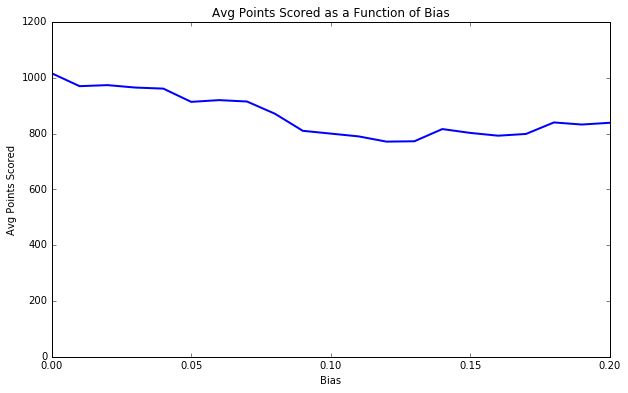

In [268]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(biases, avg_score_with_bias, lw=2)
ax.set_title("Avg Points Scored as a Function of Bias")
ax.set_xlabel("Bias")
ax.set_ylabel("Avg Points Scored")
ax.set_ylim([0, 1200])
ax.set_xlim([0, .2])

In [152]:
# compute difference from the top seed
i = 0
for year in year_range:
    # actual results
    actual_tourney = actual_tourneys[i]
    top_seed_tourney = top_seed_tourneys[i]
    unbiased_tourney = greedy_tourneys[i]
    
    j = 0
    for bias in biases:
        # get data needed
        seeds_year = seeds_arr[year-1985] 
        slots_year = slots_arr[year-1985] 
        games_year = games_arr[year-1985]
        
        # score the biased models
        n_games_dif_top_seed[i, j] = biased_tourneys[i][j].compare_to_dif_tournament(actual_tourney, top_seed_tourney, print_res=False)[0] 
        n_games_dif_unbiased[i, j] = biased_tourneys[i][j].compare_to_dif_tournament(actual_tourney, unbiased_tourney, print_res=False)[0] 
            
        j = j + 1
    i = i + 1

In [156]:
avg_number_of_games_dif_top_seed = np.average(n_games_dif_top_seed, axis=0)
avg_number_of_games_dif_unbiased = np.average(n_games_dif_unbiased, axis=0)

(0, 0.2)

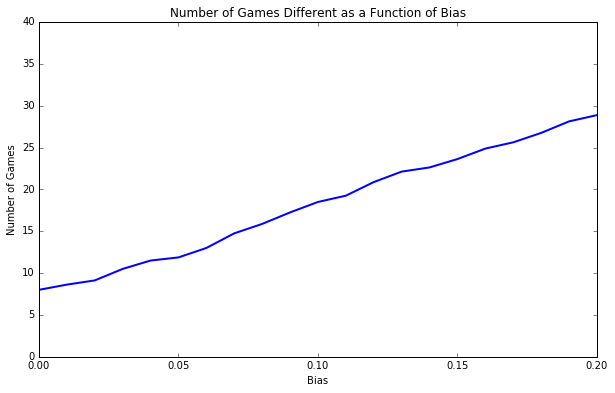

In [167]:
fig2 = plt.figure(figsize=(10,6))
ax2 = fig2.add_subplot(111)

ax2.plot(biases, avg_number_of_games_dif_top_seed, color="b", label="Top Seed", lw=2)
ax2.set_title("Number of Games Different as a Function of Bias")
ax2.set_xlabel("Bias")
ax2.set_ylabel("Number of Games")
ax2.set_ylim([0, 40])
ax2.set_xlim([0, .2])

In [191]:
points_scored_with_04_bias = avg_score_with_bias[4]
points_scored_with_00_bias = avg_score_with_bias[0]

avg_number_of_games_dif_04_bias = avg_number_of_games_dif_top_seed[4]
avg_number_of_games_dif_00_bias = avg_number_of_games_dif_top_seed[0]

In [192]:
print "Avg Points with .04 bias {}".format(points_scored_with_04_bias)
print "Avg Points with   0 bias {}".format(points_scored_with_00_bias)

print "Games Dif Than Top Seed .04 bias {}".format(avg_number_of_games_dif_04_bias)
print "Games Dif Than Top Seed   0 bias {}".format(avg_number_of_games_dif_00_bias)

Avg Points with .04 bias 961.25
Avg Points with   0 bias 1016.25
Games Dif Than Top Seed .04 bias 11.5
Games Dif Than Top Seed   0 bias 8.0


--- 
### 7) Introducing Cooling

In [294]:
early_round_upsets = {6:0, 5:0, 4:0, 3:10, 2:10, 1:10}
late_round_upsets = {6:10, 5:10, 4:10, 3:10, 2:0, 1:0}

early_round_upsets_arr = []
late_round_upsets_arr = []

i = 0
for year in year_range:

    # get data needed
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]

    # setup head to head model, with bias in the early rounds
    early_round_bias = mmm.ModelPredictor(models[i], 
                                      scalers[i],
                                      predictor_dfs,
                                      year, 
                                      simulation=False, 
                                      higher_seed_bias=True,
                                      seeds_df=seeds_year, 
                                      higher_seed_bias_delta=.007, 
                                      cooling = early_round_upsets)
    
    # setup head to head model, with bias in the early rounds
    late_round_bias = mmm.ModelPredictor(models[i], 
                                      scalers[i],
                                      predictor_dfs,
                                      year, 
                                      simulation=False, 
                                      higher_seed_bias=True,
                                      seeds_df=seeds_year, 
                                      higher_seed_bias_delta=.005, 
                                      cooling = late_round_upsets)
    
    
    # run tournaments
    early_round_upsets_arr.append(mmc.Tournament(seeds_year, slots_year, early_round_bias, include_scoring_dif=False))
    late_round_upsets_arr.append(mmc.Tournament(seeds_year, slots_year, late_round_bias, include_scoring_dif=False))
    
    i = i + 1
  

In [295]:
scores_early_round_upsets = np.zeros(max_year-min_year)
scores_late_round_upsets = np.zeros(max_year-min_year)

# score biased models with cooling
i = 0
for year in year_range:
    # actual results
    actual_tourney = actual_tourneys[i]
    
    # get data needed
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]

    # score the biased models
    scores_early_round_upsets[i] = early_round_upsets_arr[i].score_tournament(actual_tourney)[0]
    scores_late_round_upsets[i] = late_round_upsets_arr[i].score_tournament(actual_tourney)[0]  

    i = i + 1

In [296]:
scores_early_round_upsets_avg = np.average(scores_early_round_upsets)
scores_late_round_upsets_avg = np.average(scores_late_round_upsets)

In [297]:
scores_early_round_upsets_avg

995.0

In [298]:
scores_late_round_upsets_avg

916.25

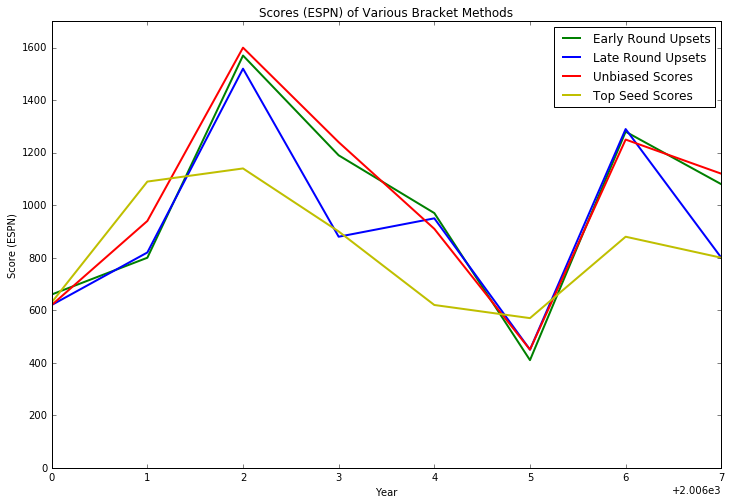

In [303]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

ax.plot(year_range, scores_early_round_upsets, c="g", label="Early Round Upsets", lw=2)
ax.plot(year_range, scores_late_round_upsets, c="b", label = "Late Round Upsets", lw=2)
ax.plot(year_range, greedy_scores, c="r", label= "Unbiased Scores", lw=2)
ax.plot(year_range, top_seed_scores, c="y", label= "Top Seed Scores", lw=2)
ax.set_xlabel("Year")
ax.set_ylabel("Score (ESPN)")
ax.set_ylim([0, 1700])
ax.set_title("Scores (ESPN) of Various Bracket Methods")
ax.legend()

In [317]:
n_games_dif_early_round = np.zeros(len(year_range)) 
n_games_dif_late_round = np.zeros(len(year_range)) 
n_games_dif_unbiased = np.zeros(len(year_range)) 
n_games_dif_location =  np.zeros(len(year_range))
n_games_dif_early_unbiased = np.zeros(len(year_range))
n_games_dif_late_unbiased = np.zeros(len(year_range))

# compute difference from the top seed
i = 0
for year in year_range:
    # actual results
    actual_tourney = actual_tourneys[i]
    top_seed_tourney = top_seed_tourneys[i]
    unbiased_tourney = greedy_tourneys[i]
    
    # get data needed
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]

    # score the biased models
    n_games_dif_early_round[i] = early_round_upsets_arr[i].compare_to_dif_tournament(actual_tourney, top_seed_tourney, print_res=False)[0] 
    n_games_dif_late_round[i]  = late_round_upsets_arr[i].compare_to_dif_tournament(actual_tourney, top_seed_tourney, print_res=False)[0] 
    n_games_dif_unbiased[i]    = unbiased_tourney.compare_to_dif_tournament(actual_tourney, top_seed_tourney, print_res=False)[0] 
    n_games_dif_location[i]    = early_round_upsets_arr[i].compare_to_dif_tournament(actual_tourney, late_round_upsets_arr[i], print_res=False)[0] 
    n_games_dif_early_unbiased[i] = early_round_upsets_arr[i].compare_to_dif_tournament(actual_tourney, unbiased_tourney, print_res=False)[0] 
    n_games_dif_late_unbiased[i] = late_round_upsets_arr[i].compare_to_dif_tournament(actual_tourney, unbiased_tourney, print_res=False)[0] 
    
    i = i + 1

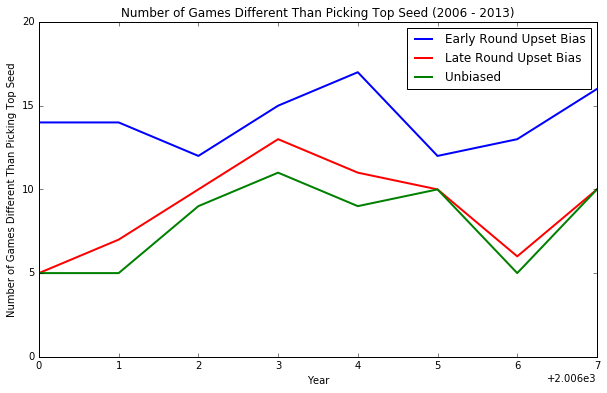

In [318]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(year_range, n_games_dif_early_round, color="b", label="Early Round Upset Bias", lw=2)
ax.plot(year_range, n_games_dif_late_round, color="r", label="Late Round Upset Bias", lw=2)
ax.plot(year_range, n_games_dif_unbiased, color="g", label="Unbiased", lw=2)
ax.set_title("Number of Games Different Than Picking Top Seed (2006 - 2013)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Games Different Than Picking Top Seed")
ax.set_ylim([0,20])
ax.legend()

(0, 15)

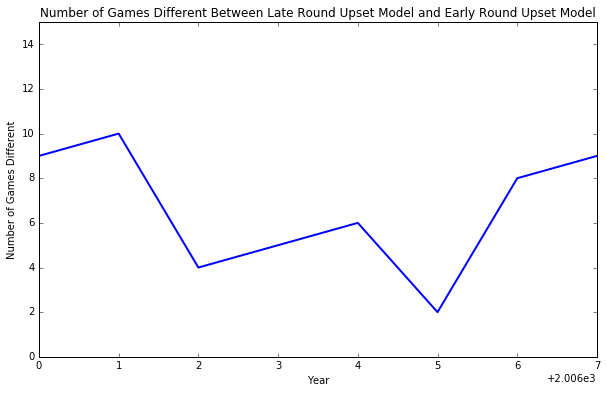

In [323]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(year_range, n_games_dif_location, color="b", label="Early Round Upset Bias", lw=2)
ax.set_title("Number of Games Different Between Late Round Upset Model and Early Round Upset Model")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Games Different")
ax.set_ylim([0,15])

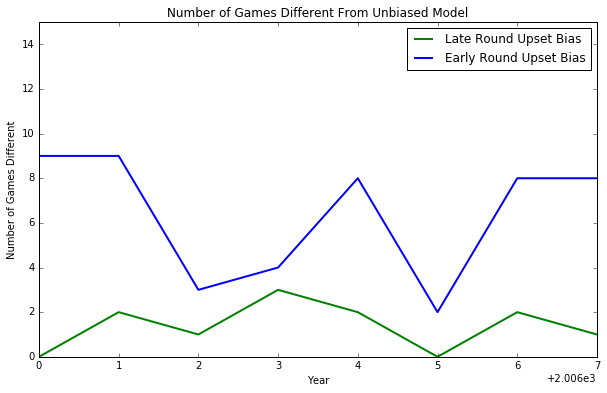

In [325]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(year_range, n_games_dif_late_unbiased, color="g", label="Late Round Upset Bias", lw=2)
ax.plot(year_range, n_games_dif_early_unbiased, color="b", label="Early Round Upset Bias", lw=2)
ax.set_title("Number of Games Different From Unbiased Model")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Games Different")
ax.set_ylim([0,15])
ax.legend()

---
### 8) 10 Bracket Mashup

In [354]:
models_10 = []

early_round_upsets = {6:0, 5:0, 4:0, 3:10, 2:10, 1:10}
late_round_upsets = {6:10, 5:10, 4:10, 3:10, 2:0, 1:0}

i = 0
for year in year_range:
    
    models_in_year_i = []

    # get data needed
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]
    
    # model 1 ######################################################################
    unbiased_model_det = mmm.ModelPredictor(models[i], 
                                      scalers[i],
                                      predictor_dfs,
                                      year, 
                                      simulation=False, 
                                      higher_seed_bias=False)
    models_in_year_i.append(mmc.Tournament(seeds_year, slots_year, unbiased_model_det, include_scoring_dif=False))
    
    # model 2 ######################################################################
    unbiased_model_undet_1 = mmm.ModelPredictor(models[i], 
                                      scalers[i],
                                      predictor_dfs,
                                      year, 
                                      simulation=True, 
                                      higher_seed_bias=False)
    
    unbiased_model_undet_1_sim = mmc.Simulator(seeds_year, slots_year, unbiased_model_undet_1)
    unbiased_model_undet_1_sim.simulate_tournament(1) 
    models_in_year_i.append(unbiased_model_undet_1_sim.predict_tournament())
    
    # model 3 ######################################################################
    unbiased_model_undet_2 = mmm.ModelPredictor(models[i], 
                                      scalers[i],
                                      predictor_dfs,
                                      year, 
                                      simulation=True, 
                                      higher_seed_bias=False)
    
    unbiased_model_undet_2_sim = mmc.Simulator(seeds_year, slots_year, unbiased_model_undet_2)
    unbiased_model_undet_2_sim.simulate_tournament(1) 
    models_in_year_i.append(unbiased_model_undet_1_sim.predict_tournament())
    
    # model 4 ######################################################################
    biased_model_det = mmm.ModelPredictor(models[i], 
                                      scalers[i],
                                      predictor_dfs,
                                      year, 
                                      simulation=False, 
                                      higher_seed_bias=True,
                                      higher_seed_bias_delta=.04,
                                      seeds_df=seeds_year)
    models_in_year_i.append(mmc.Tournament(seeds_year, slots_year, biased_model_det, include_scoring_dif=False))
    
    # model 5 ######################################################################
    biased_model_undet_1 = mmm.ModelPredictor(models[i], 
                                      scalers[i],
                                      predictor_dfs,
                                      year, 
                                      simulation=True, 
                                      higher_seed_bias_delta=.04,
                                      higher_seed_bias=True,
                                      seeds_df=seeds_year)
    
    biased_model_undet_1_sim = mmc.Simulator(seeds_year, slots_year, biased_model_undet_1)
    biased_model_undet_1_sim.simulate_tournament(1) 
    models_in_year_i.append(biased_model_undet_1_sim.predict_tournament())
    
    # model 6 ######################################################################
    biased_model_undet_2 = mmm.ModelPredictor(models[i], 
                                      scalers[i],
                                      predictor_dfs,
                                      year, 
                                      simulation=True, 
                                      higher_seed_bias_delta=.04,
                                      higher_seed_bias=True,
                                      seeds_df=seeds_year)
    
    biased_model_undet_2_sim = mmc.Simulator(seeds_year, slots_year, biased_model_undet_2)
    biased_model_undet_2_sim.simulate_tournament(1) 
    models_in_year_i.append(biased_model_undet_2_sim.predict_tournament())
    
    # model 7 ######################################################################
    early_round_bias_det = mmm.ModelPredictor(models[i], 
                                      scalers[i],
                                      predictor_dfs,
                                      year, 
                                      simulation=False, 
                                      higher_seed_bias=True,
                                      seeds_df=seeds_year, 
                                      higher_seed_bias_delta=.007, 
                                      cooling = early_round_upsets)
    models_in_year_i.append(mmc.Tournament(seeds_year, slots_year, early_round_bias_det, include_scoring_dif=False))
    
    
    # model 8 ######################################################################
    early_round_bias_undet = mmm.ModelPredictor(models[i], 
                                      scalers[i],
                                      predictor_dfs,
                                      year, 
                                      simulation=True, 
                                      higher_seed_bias=True,
                                      seeds_df=seeds_year, 
                                      higher_seed_bias_delta=.007, 
                                      cooling = early_round_upsets)
    
    early_round_bias_undet_sim = mmc.Simulator(seeds_year, slots_year, early_round_bias_undet)
    early_round_bias_undet_sim.simulate_tournament(1) 
    models_in_year_i.append(early_round_bias_undet_sim.predict_tournament())
    
    # model 9 ######################################################################
    late_round_bias_det = mmm.ModelPredictor(models[i], 
                                      scalers[i],
                                      predictor_dfs,
                                      year, 
                                      simulation=False, 
                                      higher_seed_bias=True,
                                      seeds_df=seeds_year, 
                                      higher_seed_bias_delta=.005, 
                                      cooling = late_round_upsets)
    
    models_in_year_i.append(mmc.Tournament(seeds_year, slots_year, late_round_bias_det, include_scoring_dif=False))
    
    # model 10 ######################################################################
    late_round_bias_undet = mmm.ModelPredictor(models[i], 
                                      scalers[i],
                                      predictor_dfs,
                                      year, 
                                      simulation=False, 
                                      higher_seed_bias=True,
                                      seeds_df=seeds_year, 
                                      higher_seed_bias_delta=.005, 
                                      cooling = late_round_upsets)
    
    late_round_bias_undet_sim = mmc.Simulator(seeds_year, slots_year, late_round_bias_undet)
    late_round_bias_undet_sim.simulate_tournament(1) 
    models_in_year_i.append(late_round_bias_undet_sim.predict_tournament())
    
    models_10.append(models_in_year_i)
    i = i + 1

In [355]:
scores = np.zeros((max_year - min_year, len(models_10[0])))

# score biased models with cooling
i = 0
for year in year_range:
    # actual results
    actual_tourney = actual_tourneys[i]
    
    # get data needed
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]

    # score the 10 models
    for j in range(10):
        scores[i, j] = models_10[i][j].score_tournament(actual_tourney)[0]

    i = i + 1

In [361]:
print scores
max_scores = np.max(scores, axis=1)

[[  620.   460.   460.   570.   600.   560.   660.   440.   620.   620.]
 [  940.   580.   580.   830.   480.  1100.   800.   620.   820.   820.]
 [ 1600.  1290.  1290.  1590.  1310.   660.  1570.   550.  1520.  1520.]
 [ 1240.   550.   550.  1180.   480.   410.  1190.   970.   880.   880.]
 [  910.   610.   610.   940.   450.  1170.   970.   400.   950.   950.]
 [  450.   430.   430.   450.   330.   300.   410.   580.   450.   450.]
 [ 1250.   490.   490.  1300.   420.   410.  1280.   570.  1290.  1290.]
 [ 1120.   700.   700.   830.   980.   590.  1080.   440.   800.   800.]]
1096.25
1016.25


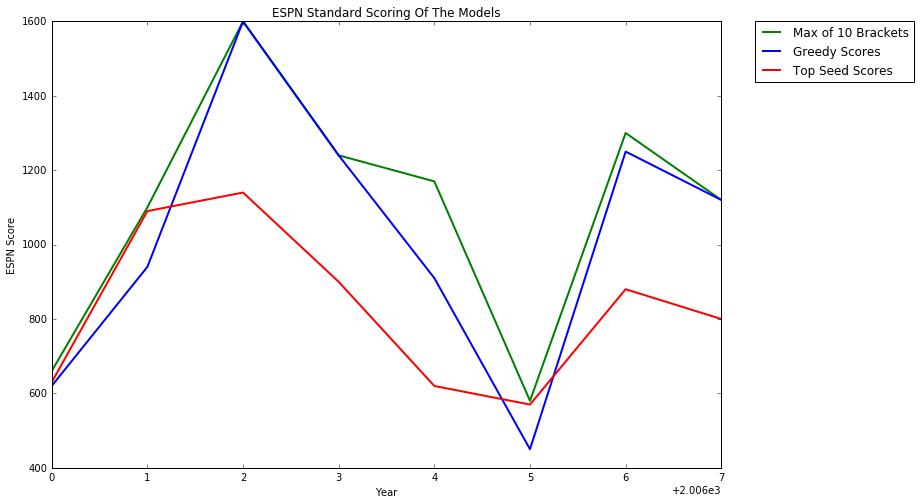

In [360]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(year_range, max_scores, c="g", label="Max of 10 Brackets", lw=2)
ax.plot(year_range, greedy_scores, c="b", label = "Greedy Scores", lw=2)
ax.plot(year_range, top_seed_scores, c="r", label= "Top Seed Scores", lw=2)
ax.set_xlabel("Year")
ax.set_ylabel("ESPN Score")
ax.set_title("ESPN Standard Scoring Of The Models")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)